In [1]:
import os
import random
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageOps, ImageEnhance
from torchvision import transforms


In [5]:
# Data augmentation to increase the size of the dataset

# Paths for Training Data and Augmented Data 

input_folder = 'C:/Users/ishitv/Desktop/jvdskg/train_data'
output_folder = 'C:/Users/ishitv/Desktop/jvdskg/augment_data'


# Check if the directory exists 
os.makedirs(output_folder, exist_ok=True)

# All tranformation : 

flip_horizontal = transforms.RandomHorizontalFlip(p=1.0)  # Always flip horizontally
flip_vertical = transforms.RandomVerticalFlip(p=1.0)      # Always flip vertically
zoom = transforms.RandomAffine(degrees=0, scale=(0.8, 1.2))
translate = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Random translation (shift) by 10%

def add_gaussian_noise(image, mean=0, stddev=25):
    np_image = np.array(image)
    noise = np.random.normal(mean, stddev, np_image.shape).astype(np.uint8)
    noisy_image = Image.fromarray(np.clip(np_image + noise, 0, 255).astype(np.uint8))
    return noisy_image


# Function to apply and save different effects
def apply_effects(img, filename):
    # Apply horizontal flip
    img_flip_h = flip_horizontal(img)
    img_flip_h.save(os.path.join(output_folder, f"{filename.split('.')[0]}_flip_h.{filename.split('.')[1]}"))

    # Apply vertical flip
    img_flip_v = flip_vertical(img)
    img_flip_v.save(os.path.join(output_folder, f"{filename.split('.')[0]}_flip_v.{filename.split('.')[1]}"))

    # Apply translation
    img_translated = translate(img)
    img_translated.save(os.path.join(output_folder, f"{filename.split('.')[0]}_translate.{filename.split('.')[1]}"))

    # Apply zoom
    img_zoomed = zoom(img)
    img_zoomed.save(os.path.join(output_folder, f"{filename.split('.')[0]}_zoom.{filename.split('.')[1]}"))

    # Apply Gaussian noise
    img_noisy = add_gaussian_noise(img)
    img_noisy.save(os.path.join(output_folder, f"{filename.split('.')[0]}_gaussian_noise.{filename.split('.')[1]}"))

# Load and augment images
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Apply different effects and save them as new images
        apply_effects(img, filename)

        print(f"{filename} processed.")


10_image_04081.jpg processed.
10_image_04082.jpg processed.
10_image_04083.jpg processed.
10_image_04084.jpg processed.
10_image_04085.jpg processed.
10_image_04086.jpg processed.
10_image_04087.jpg processed.
10_image_04088.jpg processed.
10_image_04089.jpg processed.
10_image_04090.jpg processed.
10_image_04091.jpg processed.
10_image_04092.jpg processed.
10_image_04093.jpg processed.
10_image_04094.jpg processed.
10_image_04095.jpg processed.
10_image_04096.jpg processed.
10_image_04097.jpg processed.
10_image_04098.jpg processed.
10_image_04099.jpg processed.
10_image_04100.jpg processed.
10_image_04101.jpg processed.
10_image_04102.jpg processed.
10_image_04103.jpg processed.
10_image_04104.jpg processed.
10_image_04105.jpg processed.
10_image_04106.jpg processed.
10_image_04107.jpg processed.
10_image_04108.jpg processed.
10_image_04109.jpg processed.
10_image_04110.jpg processed.
10_image_04111.jpg processed.
10_image_04112.jpg processed.
10_image_04113.jpg processed.
10_image_0

In [6]:
import cv2
import os
from skimage import feature

def read_images(img_dir, label_file):
    with open(label_file) as f:
        labels = [word.lower().strip() for word in f.read().split("\n") if word.strip()]

    labels = [eval(i) for i in labels]
    list_set = set(labels)
    corrected_labels = list(list_set)
    
    image_data = []
    
    for label in corrected_labels:
        matching_files = [f for f in os.listdir(img_dir) if f.startswith(f"{label}_image_") and f.endswith('.jpg')]
        for matching_file in matching_files:
            image_path = os.path.join(img_dir, matching_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is not None:
                image_data.append((image, label - 1))  # Store image and label
                
    return image_data

def apply_hog(image_data):
    hog_data = []
    
    for image, label in image_data:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply HOG feature extraction
        hog_features, hog_image = feature.hog(
            gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
            block_norm='L2-Hys', visualize=True, transform_sqrt=True
        )
        
        # Store the HOG features along with the label
        hog_data.append((hog_features, label))
        
    return hog_data



In [7]:
img_dir ="C:/Users/ishitv/Desktop/jvdskg/augment_data"
label_file ="C:/Users/ishitv/Desktop/jvdskg/train_labels.txt"

image_data = read_images(img_dir, label_file)
image_data = apply_hog(image_data)

print(len(image_data))

15000


In [9]:
img_dir ="C:/Users/ishitv/Desktop/jvdskg/val_data"
label_file ="C:/Users/ishitv/Desktop/jvdskg/val_labels.txt"

val_data = read_images(img_dir, label_file)
val_data = apply_hog(val_data)

print(len(val_data))


600


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

def init_pca(data, input_list, variance_threshold=0.95):
    # Prepare training features and labels
    features = []
    labels = []
    
    for (image, label) in data:
        np_array = np.array(image, dtype=np.float32)
        flattened_image = torch.tensor(np_array).reshape(-1)
        features.append(flattened_image.numpy())  # Convert to NumPy array
        labels.append(label)

    features = np.array(features)  # Convert list to a 2D NumPy array
    
    # Prepare validation features and labels
    val_pixel = []
    val_label = []
    
    for (image, label) in input_list:
        np_array = np.array(image, dtype=np.float32)
        flattened_image = torch.tensor(np_array).reshape(-1)
        val_pixel.append(flattened_image.numpy())
        val_label.append(label)

    val_pixel = np.array(val_pixel)
    
    # Fit PCA to the training data
    pca = PCA()
    pca.fit(features)

    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the number of components to reach the variance threshold
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Number of components to retain {variance_threshold * 100:.0f}% variance: {n_components}")
    
    # Plot the explained variance graph
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, color='blue', lw=2)
    plt.scatter([n_components], [cumulative_variance[n_components-1]], color='red', zorder=5)
    plt.title('Explained Variance vs Principal Components', fontsize=14)
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.axvline(x=n_components, color='green', linestyle='--', lw=1.5, label=f'{n_components} Components')
    plt.axhline(y=variance_threshold, color='orange', linestyle='--', lw=1.5, label=f'{variance_threshold * 100:.0f}% Variance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Fit PCA again with the reduced number of components
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(features)
    pca_result = pca.transform(val_pixel)
    
    # Save the PCA model using pickle
    with open('pca_model.pkl', 'wb') as f:
        pickle.dump(pca, f)
    
    return X_reduced, labels, pca_result, val_label



15000
Number of components to retain 95% variance: 6128


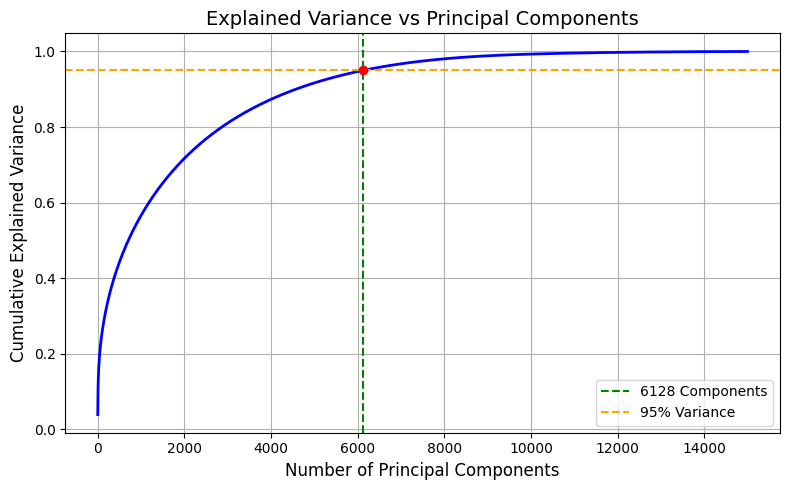

In [12]:
print(len(image_data))

images_data,labels,data_val,label_val= init_pca(image_data,val_data)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.regularizers import l1_l2
import numpy as np


X_train= np.array(images_data)
X_val= np.array(data_val)
y_train= np.array(labels)
y_val= np.array(label_val)

y_train = to_categorical(y_train, num_classes=60)
y_val = to_categorical(y_val, num_classes=60)


model = Sequential()

model.add(Dense(2048, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.5))  # Keep higher dropout in initial layers to prevent overfitting
model.add(BatchNormalization())

model.add(Dense(1024, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.4))  # Slightly reduced dropout to retain more information
model.add(BatchNormalization())

model.add(Dense(512, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-3)))
model.add(Dropout(0.3))  # Reduced dropout as the network gets smaller
model.add(BatchNormalization())

model.add(Dense(256, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))

# Output layer with 60 classes, using softmax activation
model.add(Dense(60, activation="softmax"))


print("[INFO] training network...")
sgd = SGD(learning_rate=0.01,momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val),
	epochs=20, batch_size=32)

model.save('Model.h5')

[INFO] training network...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - accuracy: 0.0293 - loss: 7.9771 - val_accuracy: 0.1050 - val_loss: 7.1425
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 124ms/step - accuracy: 0.0851 - loss: 7.2789 - val_accuracy: 0.1667 - val_loss: 6.6047
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.1330 - loss: 6.7518 - val_accuracy: 0.2267 - val_loss: 6.2357
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.1812 - loss: 6.3052 - val_accuracy: 0.2450 - val_loss: 6.0405
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.2316 - loss: 5.9255 - val_accuracy: 0.2700 - val_loss: 5.9432
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.2843 - loss: 5.5694 - val_accuracy: 0.2883 - val_loss: 5.8822
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.3277 - loss: 5.3196 - val_accuracy: 0.3000 - val_loss: 5.8315
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step -

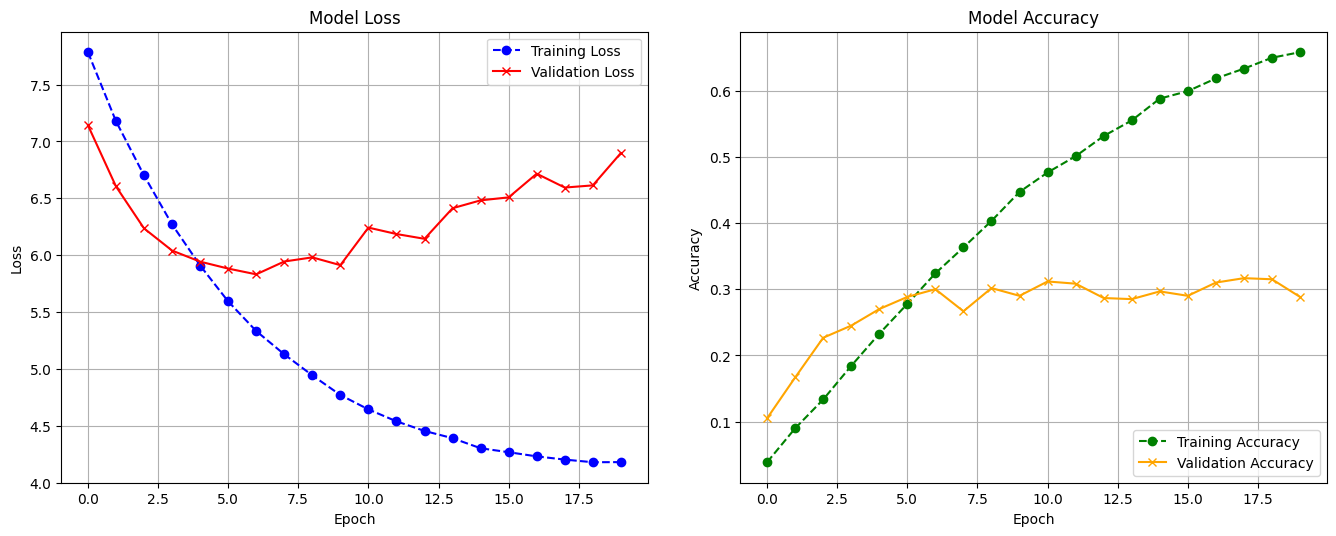

In [14]:
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], color='blue', label='Training Loss', linestyle='--', marker='o')
plt.plot(H.history['val_loss'], color='red', label='Validation Loss', linestyle='-', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], color='green', label='Training Accuracy', linestyle='--', marker='o')
plt.plot(H.history['val_accuracy'], color='orange', label='Validation Accuracy', linestyle='-', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()


## Run the below cell to download the PCA Object as well as the Model File.


In [4]:
import requests

# Direct download link from SharePoint/OneDrive
pkl_url = 'https://bitspilaniac-my.sharepoint.com/:u:/g/personal/f20212433_pilani_bits-pilani_ac_in/EVzfQoTKJwBJvoN7mZ5NPS0Bjx2O45QfExTpREmVuN5xiA?download=1'
h5_url = 'https://bitspilaniac-my.sharepoint.com/:u:/g/personal/f20212433_pilani_bits-pilani_ac_in/ER-jydWFh7VIly136CBpdt8BkVa-augvYjuXWGWa1R2ybA?download=1'
# Send a GET request to the URL
response = requests.get(pkl_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content to a local file
    with open('pca_model.pkl', 'wb') as f:
        f.write(response.content)
    print("File Downloaded")
else:
    print("Failure:", response.status_code)
    
    
response = requests.get(h5_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content to a local file
    with open('Model.h5', 'wb') as f:
        f.write(response.content)
    print("File Downloaded")
else:
    print("Failure:", response.status_code)

File downloaded successfully!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.metrics import accuracy_score
import pickle

"""
 Add the folder paths containing the test data as well as the test labels and then run the cell.
 Assumption: Test set filenames follow the format 'label_image_{some_number}.jpg',
 and the test labels are provided in a separate text file, similar to the validation and training sets.
"""

# Load the trained model
model = tf.keras.models.load_model('Model.h5')

# Path for the test dataset
test_data_path = "ADD PATH TO TEST IMAGE FOLDER"
# Path for the test labels
test_labels_path = "ADD PATH TO TEST LABEL FILE"

# Load the test labels from file
with open(test_labels_path, 'r') as label_file:
    raw_test_labels = [line.strip().lower() for line in label_file if line.strip()]

# Parse and clean the labels
t_labels = [eval(label) for label in raw_test_labels]
unique_labels = list(set(t_labels))

# Prepare the test dataset
test_images = []
for label in unique_labels:
    matching_files = [file for file in os.listdir(test_data_path) if file.startswith(f"{label}_image_") and file.endswith('.jpg')]
    
    for file in matching_files:
        image_path = os.path.join(test_data_path, file)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Extract HOG features
        hog_features, _ = hog(grayscale_image, orientations=9, pixels_per_cell=(8, 8), 
                              cells_per_block=(2, 2), block_norm='L2-Hys', 
                              visualize=True, transform_sqrt=True)
        
        test_images.append(hog_features)

# Convert list of features to a numpy array
test_images = np.array(test_images)

# Flatten images for PCA transformation
flattened_test_images = [image.flatten() for image in test_images]

# Load PCA object using pickle
with open('pca_model.pkl', 'rb') as pca_file:
    pca_transformer = pickle.load(pca_file)
test_features = pca_transformer.transform(flattened_test_images)

# Model predictions
predicted_probabilities = model.predict(test_features)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Adjust predictions as needed (e.g., if your classes start at 1 instead of 0)
final_predictions = [prediction + 1 for prediction in predicted_classes]

# Output predictions and accuracy
print("Predicted Classes:", final_predictions)

accuracy = accuracy_score(t_labels, final_predictions)
print(f'Accuracy : {accuracy * 100:.2f}%')


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Predicted Classes: [1, 22, 1, 1, 59, 1, 1, 1, 1, 1, 2, 34, 34, 30, 59, 51, 51, 42, 2, 47, 32, 44, 49, 35, 56, 3, 33, 6, 3, 44, 48, 24, 32, 56, 29, 59, 4, 11, 59, 59, 15, 5, 6, 41, 15, 33, 45, 51, 5, 21, 49, 6, 6, 33, 6, 6, 6, 6, 5, 6, 44, 7, 3, 48, 53, 2, 56, 6, 9, 47, 58, 50, 8, 8, 10, 58, 10, 8, 8, 8, 59, 24, 59, 16, 59, 23, 48, 59, 34, 57, 10, 11, 10, 10, 10, 10, 10, 41, 5, 9, 48, 4, 11, 59, 59, 36, 11, 57, 16, 4, 12, 44, 44, 40, 47, 24, 12, 12, 40, 12, 32, 23, 18, 13, 52, 40, 42, 56, 56, 59, 26, 56, 59, 14, 26, 11, 14, 9, 14, 59, 15, 21, 47, 2, 21, 13, 15, 15, 15, 5, 4, 23, 16, 26, 31, 24, 40, 16, 47, 31, 59, 26, 48, 59, 49, 40, 59, 17, 59, 59, 4, 56, 59, 59, 59, 11, 18, 11, 11, 28, 19, 19, 19, 11, 11, 34, 29, 29, 11, 19, 51, 20, 20, 57, 51, 59, 32, 55, 20, 20, 15, 17, 51, 21, 21, 41, 21, 21, 21, 59, 29, 24, 29, 24, 24, 24, 19, 29, 19, 4, 48, 27, 41, 20, 7, 54, 27, 27, 23, 32, 40, 24, 4, 51, 24, 24, 22, 46, 59, 11, 37, 36, 25, 45, 51, 25, 25,